In [2]:
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
!pip install pymannkendall
import pymannkendall as mk
from scipy import stats
from collections import Counter

from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
DATASET_PATH = '/content/drive/MyDrive/Project/AzureDataset_FunctionCalls/'
days = ['02']
days_dfs = {}
days_apps = {}
remaining_functions = []
for d in tqdm(days):
    df = pd.read_csv(DATASET_PATH+'invocations_per_function_md.anon.d'+d+'.csv')

    # remove the functions that are triggered using the timer
    df = df[~df['Trigger'].isin(['timer'])]

    # only keep function which are called at least once a minute
    def filter_(df):
        temp = df.groupby('HashFunction').sum().reset_index()
        temp['sum'] = temp[[str(i) for i in list(range(1,1441))]].sum(axis=1)
        temp = temp[temp['sum'] >= 1440]
        res = df[df['HashFunction'].isin(temp['HashFunction'].values)]
        return res
    # remove functions that are static values
    def static_filter(df):
      temp = df.groupby('HashFunction').sum().reset_index()
      # temp['max1'] = temp[[str(i) for i in list(range(1,480))]].max(axis=1)
      # temp['min1'] = temp[[str(i) for i in list(range(1,480))]].min(axis=1)
      # temp['max2'] = temp[[str(i) for i in list(range(481,961))]].max(axis=1)
      # temp['min2'] = temp[[str(i) for i in list(range(481,961))]].min(axis=1)
      # temp['max3'] = temp[[str(i) for i in list(range(961,1441))]].max(axis=1)
      # temp['min3'] = temp[[str(i) for i in list(range(961,1441))]].min(axis=1)
      # temp = temp[temp['min1'] != temp['max1']]
      # temp = temp[temp['min2'] != temp['max2']]
      # temp = temp[temp['min3'] != temp['max3']]
      temp['max'] = temp[[str(i) for i in list(range(1,1441))]].max(axis=1)
      temp['min'] = temp[[str(i) for i in list(range(1,1441))]].min(axis=1)
      temp = temp[abs(temp['min'] - temp['max']) > 20]
      res = df[df['HashFunction'].isin(temp['HashFunction'].values)]
      return res

    df = static_filter(df)
    df = filter_(df)

    if len(remaining_functions) == 0:
        remaining_functions = df['HashFunction']
    remaining_functions = np.intersect1d(df['HashFunction'], remaining_functions)


    days_dfs[d] = df

  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
print("Day 2 Stats:")
print("Unique: ", len(df['HashApp'].unique()))
print("Unique: ", len(df['HashFunction'].unique()))
print("Triggers: ", df['Trigger'].value_counts())
print("Number of services per application:", df[['HashApp','HashFunction']].groupby('HashApp').count().sort_values('HashFunction', ascending=False).value_counts())

Day 2 Stats:
Unique:  1946
Unique:  3016
Triggers:  Trigger
queue            1200
http             1003
event             434
orchestration     217
storage           116
others             46
Name: count, dtype: int64
Number of services per application: HashFunction
1               1438
2                286
3                 97
4                 46
5                 31
6                 19
8                 11
7                  9
10                 2
12                 2
15                 2
9                  1
11                 1
17                 1
Name: count, dtype: int64


In [21]:
print("Number of services per application:", df[['HashApp','HashFunction']].groupby('HashApp').count().sort_values('HashFunction', ascending=False))

Number of services per application:                                                     HashFunction
HashApp                                                         
73c0b04d46fd4f9f68723a4f0bb993f32efd450a6a98ab7...            17
482892868cd2ae0dd144842b47c7e94dbbe5d1efd8a4cb5...            15
c4af8eb43c9e02f71d4f4bbf367774167afcac3348c7e11...            15
12d3084c413e56c67b768577343300e80aaf071513141a4...            12
8f044447f82ae4606a5762193ff61b14dbf25e24a816197...            12
...                                                          ...
62c184d85af14c6c1f93c81918c2676ff2f5048b65b83fc...             1
6282034cb2caa6ff26b2800f818b7931858e7fdf591fdda...             1
61f9863a59dd1eaf90d0b3ea5c5c45c1d848db76a8ff66d...             1
61891cb9e5b925c59a7a2693b3b5d042dc4ebe283c75d68...             1
7d72367da3846b786813b8e6aa508d37369602009a3e01e...             1

[1946 rows x 1 columns]


In [5]:
%load_ext rpy2.ipython
%R install.packages('seastests', dependencies = TRUE, repos='http://cran.rstudio.com/')

(as ‘lib’ is unspecified)





































































	‘/tmp/RtmpEgqhg1/downloaded_packages’



  method            from
  as.zoo.data.frame zoo 



Test used:  Friedman rank 
 
Test statistic:  0.11 
P-value:  0.7371398



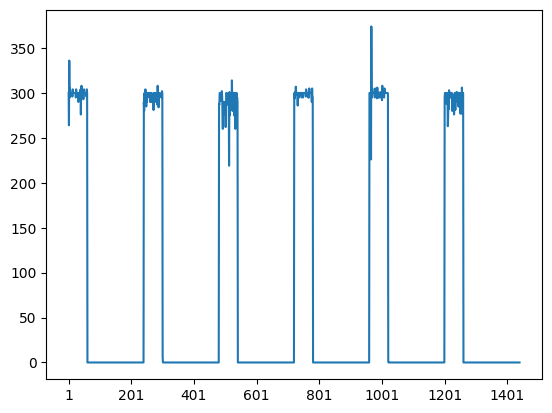

In [6]:
#Seasonality Tests, potentially will have to go back, don't trust library (turns out library is trustworthy, just dont like it)
%R library(seastests)

season_15 = {}
season_60 = {}
season_480 = {}

#for i in tqdm(range(len(df))):
for i in range(1):
  func_name = df.iloc[i].HashFunction
  temp = df.loc[df.HashFunction == "61003f5a331855f0454e64b6d866b112108b5b74a2318ad4c9bf15829323f36f"]
  temp.iloc[i,4:].T.plot()
  temp = np.asarray(temp.iloc[i,4:].T)

  qs_360 = %R -i temp isSeasonal(ts(unlist(temp), frequency = 3), test="qs")
  fried_360 = %R -i temp isSeasonal(ts(unlist(temp), frequency = 3), test="fried")
  kw_360 = %R -i temp isSeasonal(ts(unlist(temp), frequency = 3), test="kw")

  qs_60 = %R -i temp isSeasonal(ts(unlist(temp), frequency = 24), test="qs")
  fried_60 = %R -i temp isSeasonal(ts(unlist(temp), frequency = 24), test="fried")
  kw_60 = %R -i temp isSeasonal(ts(unlist(temp), frequency = 24), test="kw")

  qs_15 = %R -i temp isSeasonal(ts(unlist(temp), frequency = 96), test="qs")
  fried_15 = %R -i temp isSeasonal(ts(unlist(temp), frequency = 96), test="fried")
  kw_15 = %R -i temp isSeasonal(ts(unlist(temp), frequency = 96), test="kw")
  thing = %R fried(ts(unlist(temp), frequency=2))
  print(thing)

  if (qs_360[0] and fried_360[0]) or (qs_360[0] and kw_360[0]) or (fried_360[0] and kw_360[0]):
    season_480[func_name] = True
    print("Sweet")
  else:
    season_480[func_name] = False
  if (qs_60[0] and fried_60[0]) or (qs_60[0] and kw_60[0]) or (fried_60[0] and kw_60[0]):
    season_60[func_name] = True
  else:
    season_60[func_name] = False
  if (qs_15[0] and fried_15[0]) or (qs_15[0] and kw_15[0]) or (fried_15[0] and kw_15[0]):
    season_15[func_name] = True
  else:
    season_15[func_name] = False

In [7]:
print(qs_360[0], fried_360[0], kw_360[0])

False False False


In [8]:
#Seasonality Tests
season_15 = {}
season_60 = {}
season_180 = {}
season_480 = {}
ljungCount15 = 0
ljungCount60 = 0
ljungCount180 = 0
ljungCount480 = 0
for i in tqdm(range(len(df))):
#for i in range(2):
  func_name = df.iloc[i].HashFunction
  temp = np.asarray(df.iloc[i,4:].T)
  temp_15 = []
  temp_60 = []
  temp_180 = []
  temp_480 = []
  for l in range(int(1440/15)):
    temp_15.append(df.iloc[i,4+(l*15):4+((l+1)*15)])
  for l in range(int(1440/60)):
    temp_60.append(df.iloc[i,4+(l*60):4+((l+1)*60)])
  for l in range(int(1440/180)):
    temp_180.append(df.iloc[i,4+(l*180):4+((l+1)*180)])
  for l in range(int(1440/480)):
    temp_480.append(df.iloc[i,4+(l*480):4+((l+1)*480)])
  krus_15 = stats.kruskal(*temp_15)
  friedman_15 = stats.friedmanchisquare(*temp_15)
  # ljung_15 = sm.stats.acorr_ljungbox(temp, period = 1440/15)
  krus_60 = stats.kruskal(*temp_60)
  friedman_60 = stats.friedmanchisquare(*temp_60)
  # ljung_60 = sm.stats.acorr_ljungbox(temp, period = 1440/60)
  krus_180 = stats.kruskal(*temp_180)
  friedman_180 = stats.friedmanchisquare(*temp_180)
  # ljung_60 = sm.stats.acorr_ljungbox(temp, period = 1440/60)
  krus_480 = stats.kruskal(*temp_480)
  friedman_480 = stats.friedmanchisquare(*temp_480)
  # ljung_480 = sm.stats.acorr_ljungbox(temp, period = 1440/480)
  ljung_480 = %R -i temp qs(ts(unlist(temp), frequency = 3), freq = NA, diff = F, residuals = F, autoarima = T)
  ljung_180 = %R -i temp qs(ts(unlist(temp), frequency = 8), freq = NA, diff = F, residuals = F, autoarima = T)
  ljung_60 = %R -i temp qs(ts(unlist(temp), frequency = 24), freq = NA, diff = F, residuals = F, autoarima = T)
  ljung_15 = %R -i temp qs(ts(unlist(temp), frequency = 96), freq = NA, diff = F, residuals = F, autoarima = T)
  if (ljung_15[1][0] < 0.05):
    ljungCount15 += 1
  if (ljung_60[1][0] < 0.05):
    ljungCount60 += 1
  if (ljung_180[1][0] < 0.05):
    ljungCount180 += 1
  if (ljung_480[1][0] < 0.05):
    ljungCount480 += 1
  if (ljung_480[1][0] < 0.05 and friedman_480.pvalue >= 0.05) or (ljung_480[1][0] < 0.05 and krus_480.pvalue >= 0.05) or (friedman_480.pvalue >= 0.05 and krus_480.pvalue >= 0.05):
    season_480[func_name] = True
  else:
    season_480[func_name] = False
  if (ljung_180[1][0] < 0.05 and friedman_180.pvalue >= 0.05) or (ljung_180[1][0] < 0.05 and krus_180.pvalue >= 0.05) or (friedman_180.pvalue >= 0.05 and krus_180.pvalue >= 0.05):
    season_180[func_name] = True
  else:
    season_180[func_name] = False
  if (ljung_60[1][0] < 0.05 and friedman_60.pvalue >= 0.05) or (ljung_60[1][0] < 0.05 and krus_60.pvalue >= 0.05) or (friedman_60.pvalue >= 0.05 and krus_60.pvalue >= 0.05):
    season_60[func_name] = True
  else:
    season_60[func_name] = False
  if (ljung_15[1][0] < 0.05 and friedman_15.pvalue >= 0.05) or (ljung_15[1][0] < 0.05 and krus_15.pvalue >= 0.05) or (friedman_15.pvalue >= 0.05 and krus_15.pvalue >= 0.05):
    season_15[func_name] = True
  else:
    season_15[func_name] = False
  # if (ljung_15.lb_pvalue.min() < 0.05):
  #   ljungCount15 += 1
  # if (ljung_60.lb_pvalue.min() < 0.05):
  #   ljungCount60 += 1
  # if (ljung_480.lb_pvalue.min() < 0.05):
  #   ljungCount480 += 1
  # if (ljung_480.lb_pvalue.min() < 0.05 and friedman_480.pvalue >= 0.05) or (ljung_480.lb_pvalue.min() < 0.05 and krus_480.pvalue >= 0.05) or (friedman_480.pvalue >= 0.05 and krus_480.pvalue >= 0.05):
  #   season_480[func_name] = True
  # else:
  #   season_480[func_name] = False
  # if (ljung_60.lb_pvalue.min() < 0.05 and friedman_60.pvalue >= 0.05) or (ljung_60.lb_pvalue.min() < 0.05 and krus_60.pvalue >= 0.05) or (friedman_60.pvalue >= 0.05 and krus_60.pvalue >= 0.05):
  #   season_60[func_name] = True
  # else:
  #   season_60[func_name] = False
  # if (ljung_15.lb_pvalue.min() < 0.05 and friedman_15.pvalue >= 0.05) or (ljung_15.lb_pvalue.min() < 0.05 and krus_15.pvalue >= 0.05) or (friedman_15.pvalue >= 0.05 and krus_15.pvalue >= 0.05):
  #   season_15[func_name] = True
  # else:
  #   season_15[func_name] = False

  0%|          | 0/3016 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:9427: RuntimeWarning: invalid value encountered in scalar divide
  chisq = (12.0 / (k*n*(k+1)) * ssbn - 3*n*(k+1)) / c


In [9]:
print(ljungCount15, ljungCount60, ljungCount180, ljungCount480)

1170 1670 1932 2158


In [10]:
print(Counter(season_15.values()))
print(Counter(season_60.values()))
print(Counter(season_180.values()))
print(Counter(season_480.values()))

Counter({False: 2665, True: 351})
Counter({False: 2673, True: 343})
Counter({False: 2668, True: 348})
Counter({False: 2547, True: 469})


In [11]:
trueSeason_15 = {}
trueSeason_60 = {}
trueSeason_180 = {}
trueSeason_480 = {}
for key, val in season_15.items():
    if val:
      trueSeason_15[key] = val
for key, val in season_60.items():
    if val:
      trueSeason_60[key] = val
for key, val in season_180.items():
    if val:
      trueSeason_180[key] = val
for key, val in season_480.items():
    if val:
      trueSeason_480[key] = val
print(len(trueSeason_15.keys() - trueSeason_60.keys() - trueSeason_180.keys() - trueSeason_480.keys()))
print(len(trueSeason_60.keys() - trueSeason_15.keys() - trueSeason_180.keys() - trueSeason_480.keys()))
print(len(trueSeason_180.keys() - trueSeason_15.keys() - trueSeason_60.keys() - trueSeason_480.keys()))
print(len(trueSeason_480.keys() - trueSeason_60.keys() - trueSeason_180.keys() - trueSeason_15.keys()))

66
5
4
104


In [12]:
no = False
if no:
  season_15L = ['15']
  season_60L = ['60']
  season_180L = ['180']
  season_480L = ['480']
  hashFuncs = ['HashFunction']
  hashApps = ['HashApp']

  for d in df.HashFunction:
    if(season_15[d] or season_60[d] or season_180[d] or season_480[d]):
      hashFuncs.append(d)
      hashApps.append(df.loc[df.HashFunction == d].HashApp.item())
      season_15L.append(season_15[d])
      season_60L.append(season_60[d])
      season_180L.append(season_180[d])
      season_480L.append(season_480[d])
  np.savetxt('Seasonality.csv', [p for p in zip(season_15L, season_60L, season_180L, season_480L)], delimiter=',', fmt='%s')

In [14]:
#Stationarity Tests
datasets = {}
kpss_dict = {}
adfuller_dict = {}

for i in range(len(df)):
#for i in range(1):
  temp = []
  # for l in range(int(1440/480)):
  #   temp.append(df.iloc[i,4+(l*480):4+((l+1)*480)].T)
  # datasets[df.iloc[i].HashFunction] = np.asarray(temp)
  datasets[df.iloc[i].HashFunction] = [np.asarray(df.iloc[i,4:].T)]


def calculate_stationarity_percentage(datasets, p_value_threshold=0.05):
    for i , dataset in tqdm(datasets.items()):
      adf_count = 0
      kps_count = 0
      for series in dataset:
        result = adfuller(series, autolag='AIC')
        p_value = result[1]
        if p_value < p_value_threshold:
          adf_count += 1
        res = sm.tsa.stattools.kpss(series)
        if(res[1] > p_value_threshold):
          kps_count +=1
      adfuller_dict[i] = adf_count
      kpss_dict[i] = kps_count
      # adfuller_dict[i] = round(adf_count/3)
      # kpss_dict[i] = round(kps_count/3)

# Calculate the percentage of stationary time series in the dataset
calculate_stationarity_percentage(datasets)

  0%|          | 0/3016 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
<ipython-input-14-62264270c42f>:24: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  res = sm.tsa.stattools.kpss(series)
<ipython-input-14-62264270c42f>:24: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  res = sm.tsa.stattools.kpss(series)
<ipython-input-14-62264270c42f>:24: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  res = sm.tsa.stattools.kpss(series)
<ipython-input-14-62264270c42f>:24: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  res = sm.tsa.stattool

In [15]:
print(Counter(kpss_dict.values()))
print(Counter(adfuller_dict.values()))

Counter({0: 1813, 1: 1203})
Counter({1: 2227, 0: 789})


In [16]:
print(kpss_dict['bde06c0fbc47763c3c3612154de4a65e13988a6c8d7e0269baf89148a0fea9fa'], adfuller_dict['bde06c0fbc47763c3c3612154de4a65e13988a6c8d7e0269baf89148a0fea9fa'])
print(kpss_dict['2c5d363481a100391a50d5397fece786de8d4b86fc02c8880a78bcfa7b297139'], adfuller_dict['2c5d363481a100391a50d5397fece786de8d4b86fc02c8880a78bcfa7b297139'])

0 0
0 0


In [17]:
#Trend tests
datasets = {}
for i in tqdm(range(len(df))):
#for i in range(1):
  datasets[df.iloc[i].HashFunction] = np.asarray(df.iloc[i,4:].T)
 #temp = df.loc[df.HashFunction == '0b457d358285ce6a2337cf4c69d227e8c1e0d6925782c0dc1d876fdef7bf1e06']
 #datasets[df.iloc[i].HashFunction] = np.asarray(temp.iloc[i,4:].T)

trend_data = {}
def calculate_trend(datasets):
    for i , dataset in tqdm(datasets.items()):
      result = mk.original_test(dataset)
      trend_data[i] = result[0]

    return trend_data

# Calculate the percentage of stationary time series in the dataset
trend_info = calculate_trend(datasets)

  0%|          | 0/3016 [00:00<?, ?it/s]

  0%|          | 0/3016 [00:00<?, ?it/s]

In [18]:
Counter(trend_info.values())

Counter({'increasing': 1325, 'no trend': 896, 'decreasing': 795})

In [75]:
season_15L = ['season_15']
season_60L = ['season_60']
season_180L = ['season_180']
season_480L = ['season_480']
stationaryL = ['stationary']
seasonal = ['seasonal']
adFullerList = ['adfuller']
kpssList = ['kpss']
trendList = ['trend']
hashFuncs = ['HashFunction']
hashApps = ['HashApp']
for d in df.HashFunction:
  hashFuncs.append(d)
  hashApps.append(df.loc[df.HashFunction == d].HashApp.item())
  trendList.append(trend_info[d])
  if(season_15[d] or season_60[d] or season_180[d] or season_480[d]):
    seasonal.append(True)
  else:
    seasonal.append(False)
  if(kpss_dict[d] == 1 and adfuller_dict[d] == 1):
    stationaryL.append(True)
  else:
    stationaryL.append(False)
np.savetxt('HashfunctionTestsSimple_QS_New.csv', [p for p in zip(hashApps, hashFuncs, seasonal, stationaryL, trendList)], delimiter=',', fmt='%s')

In [85]:
thinger = pd.read_csv('HashfunctionTestsSimple_QS_New'+'.csv')
#print(thinger)
multiApp = df[['HashApp','HashFunction']].groupby('HashApp').count().sort_values('HashFunction', ascending=False)
onlyApp = multiApp.loc[multiApp['HashFunction'] > 1]
onlyApp = onlyApp.index
isSame = 0
isDiff = 0
isSameTot = 0
isDiffTot = 0
#for ser in ['14456d07da6db5da228beff3ad356f824e4cd09a8d6771089eb26a862526ac9a']:
for ser in onlyApp:
  temp = thinger['HashFunction'].loc[thinger['HashApp'] == ser]
  results = []
  isSameTemp = True
  for t in temp:
    results.append(thinger[['seasonal','stationary', 'trend']].loc[thinger['HashFunction'] == t].values)
  for result in results:
    #print(results[0], result)
    isSameTemp = (results[0]==result).all()
  #print(isSameTemp)
  if isSameTemp.all():
    isSame +=1
  else:
    isDiff +=1
  if isSameTemp.all():
    isSameTot +=len(results)
  else:
    isDiffTot +=len(results)
print(isSame, " ", isDiff)
print(isSameTot, " ", isDiffTot)


317   191
990   588


In [ ]:
name = 'a6eea53e4b5a25428b9f1effee32221f52132d5fd09cd2db586b4c3c1509bd80'
wack = df.loc[df.HashFunction == name]
tempf = wack.iloc[0,4:]
temp_480 = []
temp = np.asarray(wack.iloc[0,4:].T)
temp_15 = []
temp_60 = []
temp_480 = []
for l in range(int(1440/15)):
  temp_15.append(wack.iloc[0,4+(l*15):4+((l+1)*15)])
for l in range(int(1440/60)):
  temp_60.append(wack.iloc[0,4+(l*60):4+((l+1)*60)])
for l in range(int(1440/480)):
  temp_480.append(wack.iloc[0,4+(l*480):4+((l+1)*480)])
krus_15 = stats.kruskal(*temp_15)
friedman_15 = stats.friedmanchisquare(*temp_15)
# ljung_15 = sm.stats.acorr_ljungbox(temp, period = 1440/15)
krus_60 = stats.kruskal(*temp_60)
friedman_60 = stats.friedmanchisquare(*temp_60)
# ljung_60 = sm.stats.acorr_ljungbox(temp, period = 1440/60)
krus_480 = stats.kruskal(*temp_480)
friedman_480 = stats.friedmanchisquare(*temp_480)
# ljung_480 = sm.stats.acorr_ljungbox(temp, period = 1440/480)
ljung_480 = %R -i temp qs(ts(unlist(temp), frequency = 3), freq = NA, diff = F, residuals = F, autoarima = T)
ljung_60 = %R -i temp qs(ts(unlist(temp), frequency = 24), freq = NA, diff = F, residuals = F, autoarima = T)
ljung_15 = %R -i temp qs(ts(unlist(temp), frequency = 96), freq = NA, diff = F, residuals = F, autoarima = T)

print("15: ", krus_15.pvalue >= 0.05, friedman_15.pvalue >= 0.05, ljung_15[1][0] < 0.05)
print("60: ", krus_60.pvalue >= 0.05, friedman_60.pvalue >= 0.05, ljung_60[1][0] < 0.05)
print("480: ", krus_480.pvalue >= 0.05, friedman_480.pvalue >= 0.05, ljung_480[1][0] < 0.05)
df.loc[df.HashFunction == name].iloc[0,4:].T.plot()

UsageError: Line magic function `%R` not found.


<Axes: >

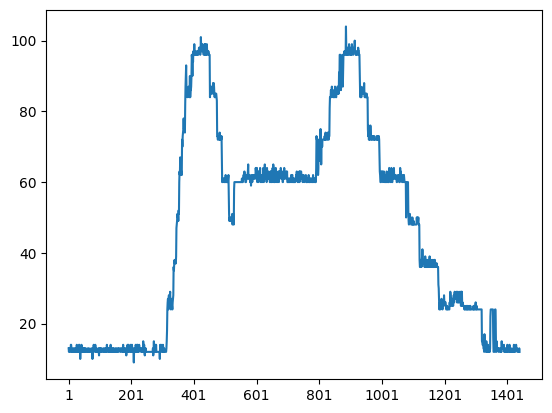

In [ ]:
name = '30bdb991ab9a0ebc1ffdd863ab6f2a19c75bb87b9db6803cec446a14bcaba263'
df.loc[df.HashFunction == name].iloc[0,4:].T.plot()
#30bdb991ab9a0ebc1ffdd863ab6f2a19c75bb87b9db6803cec446a14bcaba263
#fc057d59a3476406c8572dbab8247d7e981c1976e8403d3715979bb1c02fb846